In [1]:
# importing required libraries
import pandas as pd
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
import joblib
from imblearn.over_sampling import SMOTE

In [2]:
dataframe = pd.read_csv('cleaned_data.csv')
dataframe.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,target,ID
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1,842302
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1,842517
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1,84300903
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1,84348301
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1,84358402


In [3]:
# Separate data into Features and Target
y = dataframe.target.values
X = dataframe.drop(columns=['ID','target'])

In [4]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [5]:
# Initialize XGBClassifier
clf = XGBClassifier()

In [6]:
# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [7]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [8]:
# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [9]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test)

print("Test Accuracy:", accuracy)

Test Accuracy: 0.965034965034965


In [10]:
# Create the XGBoost instance using Best Hyperparameters
model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=50)

In [11]:
# Fit the model using no scaler
model = model.fit(X_train, y_train)

In [13]:
# Making predictions using the testing data
predictions = model.predict(X_test)

In [14]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [15]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,90,0
Actual 1,3,50


Accuracy Score : 0.9790209790209791
Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        90
           1       1.00      0.94      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.97      0.98       143
weighted avg       0.98      0.98      0.98       143



In [16]:
#  calculate feature importance
importances = model.feature_importances_
# We can sort the features by their importance
sorted(zip(model.feature_importances_, X.columns), reverse=True)

[(0.47565106, 'perimeter3'),
 (0.17466314, 'concave_points1'),
 (0.062404152, 'concave_points3'),
 (0.034542173, 'area1'),
 (0.026439343, 'concavity3'),
 (0.021824887, 'texture1'),
 (0.019453757, 'radius3'),
 (0.018975854, 'texture3'),
 (0.018653294, 'area3'),
 (0.017084388, 'compactness3'),
 (0.012700804, 'concavity2'),
 (0.012672733, 'fractal_dimension3'),
 (0.011929374, 'perimeter2'),
 (0.011433123, 'radius2'),
 (0.011346874, 'area2'),
 (0.009726129, 'fractal_dimension2'),
 (0.008541717, 'compactness2'),
 (0.008225526, 'smoothness3'),
 (0.0072829234, 'symmetry1'),
 (0.006561165, 'smoothness1'),
 (0.004967152, 'compactness1'),
 (0.0047106245, 'fractal_dimension1'),
 (0.0043608923, 'symmetry3'),
 (0.004199119, 'concave_points2'),
 (0.0040446124, 'radius1'),
 (0.003830111, 'smoothness2'),
 (0.0022029132, 'symmetry2'),
 (0.0013959694, 'concavity1'),
 (0.00017618886, 'perimeter1'),
 (0.0, 'texture2')]

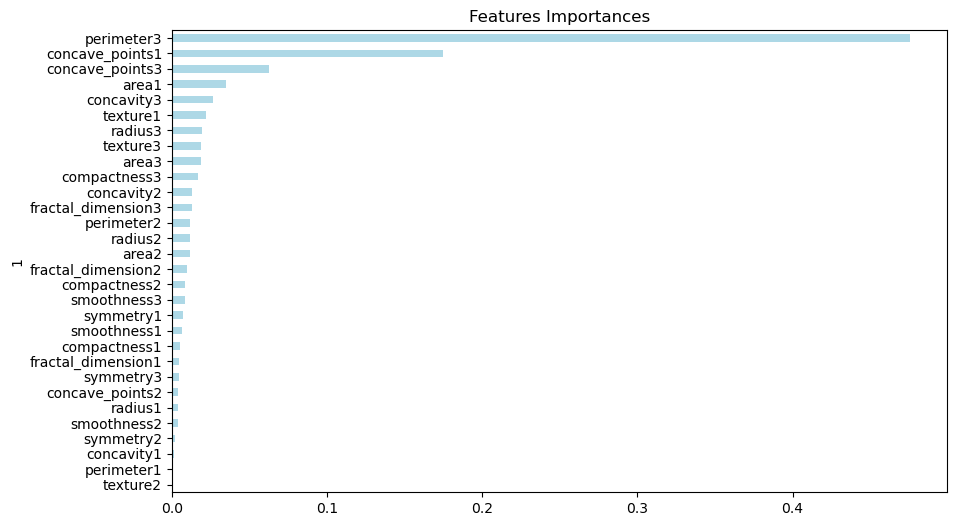

In [17]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
df_plot = importances_sorted.plot(kind='barh', color='lightblue', title= 'Features Importances', legend=False, figsize=(10, 6))

In [18]:
filename = 'XGBoost_model'
joblib.dump(model, filename)

['XGBoost_model']